In [ ]:
# Classification using multiple algorithms - Decision Tree, Random Forest, Logistic Regression, XG GBoost and Navie Bayes

# Random Forest Classifier
# Random forest is an ensemble learning method for classification that takes the majority vote from multiple decision trees to improve accuracy and reduce overfitting.
# It uses bagging (bootstrap aggregating) to create diverse trees by training each tree on a random subset of the data and features.
# Every tree in the forest votes for a class, and the class with the most votes is chosen as the final prediction.
# Every tree is independent, making random forests robust and effective for various classification tasks.

# Decision Tree Classifier
# A decision tree is a flowchart-like structure used for classification tasks.
# It splits the data into subsets based on feature values, creating branches that lead to decision nodes and leaf nodes.
# Each internal node represents a feature, each branch represents a decision rule, and each leaf node represents a class label.
# The tree is built by recursively partitioning the data to maximize information gain or minimize impurity (e.g., Gini impurity or entropy).
# Decision trees are easy to interpret and visualize, making them popular for classification problems.

# Logistic Regression Classifier
# Logistics regression is a classification algorithm which uses sigmoid function to predict the output
# Cost function used is log loss function

# XG GBoost Classifier
# XGBoost is an ensemble of weak learners (typically decision trees) in a sequential manner, where each new tree corrects the errors of the previous ones.

# Naive Bayes Classifier
# Naive Bayes is a probabilistic classifier based on Bayes' theorem, assuming independence between features.
# It calculates the posterior probability of each class given the input features and assigns the class with the highest probability.

# Implementation
	# a. Data Preprocessing - 
		# Data Standardisation - Scaling the data to have mean 0 and variance 1 -> Only for Logistic Regression
     	# Train Test Split - Splitting the data into training and testing sets
     	# Balancing the Data - Using SMOTE to balance the data
 	# b. Model Building -
     		# Grid Search CV - Hyperparameter tuning using GridSearchCV
     		# Model Training - Training the model on the training data
 	# c. Model Evaluation -
     		# Confusion Matrix - Evaluating the model using confusion matrix
     		# Classification Report - Evaluating the model using classification report
     		# ROC AUC Curve - Evaluating the model using ROC AUC curve


In [81]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [82]:
#load dataset
dataset = pd.read_csv('wireless_churn.csv')
dataset.head()

,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,Churn
0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0,0
1,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7,0
2,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2,0
3,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6,0
4,75,0,0,0.0,3,166.7,113,41.0,7.42,10.1,0


In [64]:
#Create Profile Report
 
#Importing package
import pandas as pd
#import pandas_profiling as pp
from ydata_profiling import ProfileReport
from IPython.display import IFrame
from pydantic_settings import BaseSettings
 
# Profile Report
WheatReport = ProfileReport(dataset)
WheatReport.to_file('wireless_churn.html')
display(IFrame('wireless_churn.html', width=900, height=350))

In [83]:
#Prepare for Models for Comparison

#Create x and y variables
x = dataset.drop('Churn', axis=1).to_numpy()
Y = dataset['Churn'].to_numpy()

#Load Library for Training
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size = 0.2,stratify=Y,random_state = 100)

In [84]:
# Use built-in isolation forest
from sklearn.ensemble import IsolationForest

# The prediction returns 1 if sample point is inlier. If outlier prediction returns -1
clf_all_features = IsolationForest(random_state=100)
clf_all_features.fit(x_train)

#Predict if a particular sample is an outlier using all features for higher dimensional data set.
y_pred_train = clf_all_features.predict(x_train)
y_pred_train2 =np.array(list(map(lambda x: x == 1, y_pred_train)))

# Exclude suggested outlier samples for improvement of prediction power/score
x_train_mod = x_train[y_pred_train2, ]
y_train_mod = y_train[y_pred_train2, ]

#Size of Datasets
print('Original Train Dataset Size : {}'.format(len(x_train)))
print('New Train Dataset Size      : {}'.format(len(x_train_mod)))

Original Train Dataset Size : 2666
New Train Dataset Size      : 2124


In [85]:
print('Class Split')


finalData = pd.DataFrame(y_train_mod)
print(finalData[0].value_counts())

Class Split
0    1871
1     253
Name: 0, dtype: int64


In [86]:
#Fix the imbalanced Classes
from imblearn.over_sampling import SMOTE
smt=SMOTE(random_state=100)
x_train_mod,y_train_mod = smt.fit_resample(x_train_mod,y_train_mod)

In [87]:
print('Class Split')


finalData = pd.DataFrame(y_train_mod)
print(finalData[0].value_counts())

Class Split
1    1871
0    1871
Name: 0, dtype: int64


In [88]:
#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train_mod)
x_test2 = sc.fit_transform(x_test)

x_2 = sc.fit_transform(x)

#Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [89]:
#Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

#Create Pipeline

pipeline =[]

pipe_rdf = Pipeline([('scl', StandardScaler()),
                    ('clf', RandomForestClassifier(random_state=100))])
pipeline.insert(0,pipe_rdf)

pipe_dt = Pipeline([('scl', StandardScaler()),
                    ('clf', DecisionTreeClassifier(random_state=100))])
pipeline.insert(1,pipe_dt)

# Set grid search params 

modelpara =[]

param_gridrdf = {
            'clf__criterion':['gini','entropy'
                             ],
            'clf__n_estimators': [100,150,200],
            'clf__bootstrap': [True, False]}
modelpara.insert(0,param_gridrdf)

max_depth = range(1,100)
param_griddt = {'clf__criterion':['gini','entropy'],
                'clf__max_depth':max_depth}
modelpara.insert(1,param_griddt)


In [90]:
pipe_logreg = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(multi_class='multinomial',solver='lbfgs',
                                               random_state=100,max_iter=40000, class_weight='balanced'))])
pipeline.insert(2,pipe_logreg)

#Set grid search params 



param_gridlogreg = {'clf__C': [0.01, 0.1, 1, 10, 100], 
                    'clf__penalty': ['l2'],
                   'clf__solver':['newton-cg', 'sag', 'saga' , 'lbfgs']}
modelpara.insert(2,param_gridlogreg)

In [91]:
from sklearn.naive_bayes import GaussianNB

pipe_gnb = Pipeline([('scl', StandardScaler()),
                    ('clf', GaussianNB())])
pipeline.insert(3, pipe_gnb)

param_gridgnb = { 'clf__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6] }
modelpara.insert(3,param_gridgnb)

In [92]:
#Define Plot for learning curve

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train_mod, 
                                                            y=y_train_mod,
                                                            train_sizes= np.linspace(0.1, 1.0, 10),
                                                            cv=10,
                                                            scoring='recall_weighted',random_state=100)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.ylim([0.5, 1.01])
    plt.show()

Decision Tree - Learning Curve


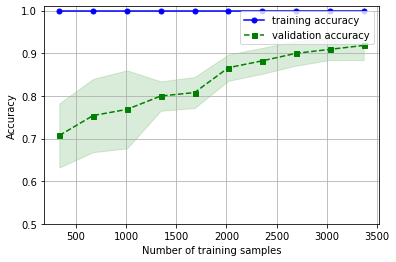


Random Forest - Learning Curve


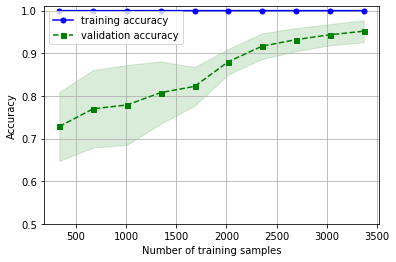

In [93]:
#Plot Learning Curve
print('Decision Tree - Learning Curve')
plot_learning_curves(pipe_dt)
print('\nRandom Forest - Learning Curve')
plot_learning_curves(pipe_rdf)


Logistics Regression - Learning Curve


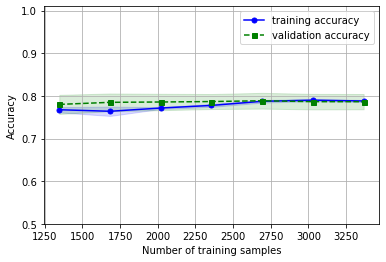

In [94]:
print('\nLogistics Regression - Learning Curve')
plot_learning_curves(pipe_logreg)


Naive Bayes Regression - Learning Curve


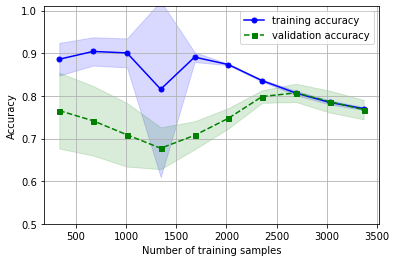

In [95]:
print('\nNaive Bayes Regression - Learning Curve')
plot_learning_curves(pipe_gnb)

Model Evaluation - Accuracy Score
Decision Tree 0.92
Random Forest 0.95
Logistics Regression 0.79
Gaussian Naive Bayes 0.77




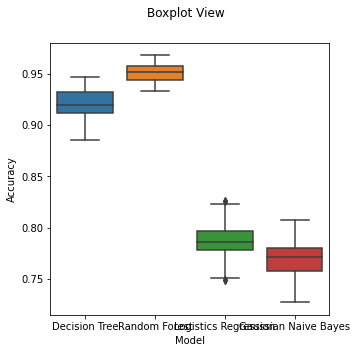

In [96]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('Decision Tree',pipe_dt))
models.append(('Random Forest',pipe_rdf))
models.append(('Logistics Regression', pipe_logreg))
models.append(('Gaussian Naive Bayes', pipe_gnb))

#Model Evaluation
results =[]
names=[]
scoring ='accuracy'
print('Model Evaluation - Accuracy Score')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x_train_mod,y_train_mod,cv=rkf,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    #print('{} {:.2f} +/- {:.2f}'.format(name,cv_results.mean(),cv_results.std()))
    print('{} {:.2f}'.format(name,cv_results.mean(),cv_results.std()))
print('\n')

fig = plt.figure(figsize=(5,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.show()

In [97]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, cv=cv2,scoring='recall_weighted')
    gs_clf = gs_clf.fit(x_train_mod, y_train_mod)
    model = gs_clf.best_estimator_
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test2)
    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Heading
    print('\nOptimized Model')
    print('\nModel Name:',str(model.named_steps['clf']))
        
    if str(model.named_steps['clf']).__contains__('GaussianNB') == False and str(model.named_steps['clf']).__contains__('Logistic') == False:
        #Feature Importance - optimized
        print('Feature Importances')
        for name, score in zip(list(dataset),gs_clf.best_estimator_.named_steps['clf'].feature_importances_):
            print(name, round(score,2))
    
    #Output Validation Statistics
    print('\nBest Parameters:',bestpara)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred))   
    
    #Transform the variables into binary (0,1) - ROC Curve
    from sklearn import preprocessing
    Forecast1=pd.DataFrame(y_pred)
    Outcome1=pd.DataFrame(y_test)
    lb1 = preprocessing.LabelBinarizer()
    OutcomeB1 =lb1.fit_transform(Outcome1)
    ForecastB1 = lb1.fit_transform(Forecast1)
    
    #Setup the ROC Curve
    from sklearn.metrics import roc_curve, auc
    from sklearn import metrics
    fpr, tpr, threshold = metrics.roc_curve(OutcomeB1, ForecastB1)
    roc_auc = metrics.auc(fpr, tpr)
    print('ROC Curve')
    #Plot the ROC Curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()   


Optimized Model

Model Name: RandomForestClassifier(random_state=100)
Feature Importances
AccountWeeks 0.05
ContractRenewal 0.11
DataPlan 0.04
DataUsage 0.07
CustServCalls 0.22
DayMins 0.17
DayCalls 0.05
MonthlyCharge 0.17
OverageFee 0.07
RoamMins 0.05

Best Parameters: {'clf__bootstrap': True, 'clf__criterion': 'gini', 'clf__n_estimators': 100}

 [[216 354]
 [ 28  69]]

               precision    recall  f1-score   support

           0       0.89      0.38      0.53       570
           1       0.16      0.71      0.27        97

    accuracy                           0.43       667
   macro avg       0.52      0.55      0.40       667
weighted avg       0.78      0.43      0.49       667

ROC Curve


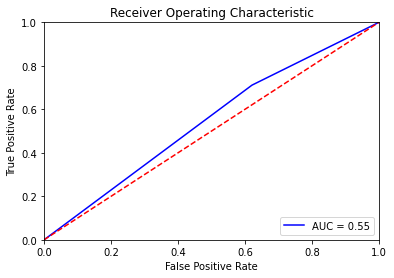


Optimized Model

Model Name: DecisionTreeClassifier(criterion='entropy', max_depth=14, random_state=100)
Feature Importances
AccountWeeks 0.03
ContractRenewal 0.14
DataPlan 0.01
DataUsage 0.02
CustServCalls 0.32
DayMins 0.23
DayCalls 0.03
MonthlyCharge 0.06
OverageFee 0.11
RoamMins 0.05

Best Parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 14}

 [[ 42 528]
 [ 25  72]]

               precision    recall  f1-score   support

           0       0.63      0.07      0.13       570
           1       0.12      0.74      0.21        97

    accuracy                           0.17       667
   macro avg       0.37      0.41      0.17       667
weighted avg       0.55      0.17      0.14       667

ROC Curve


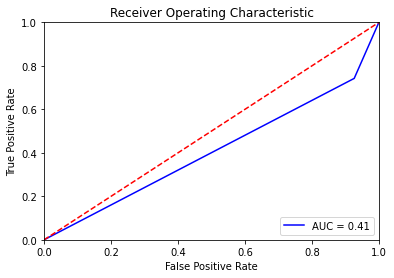


Optimized Model

Model Name: LogisticRegression(C=0.01, class_weight='balanced', max_iter=40000,
                   multi_class='multinomial', random_state=100)

Best Parameters: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

 [[529  41]
 [ 73  24]]

               precision    recall  f1-score   support

           0       0.88      0.93      0.90       570
           1       0.37      0.25      0.30        97

    accuracy                           0.83       667
   macro avg       0.62      0.59      0.60       667
weighted avg       0.80      0.83      0.81       667

ROC Curve


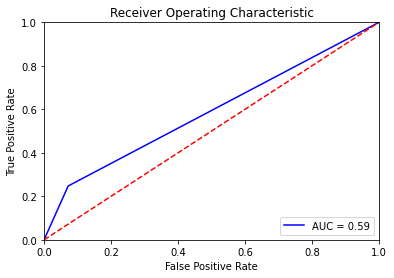


Optimized Model

Model Name: GaussianNB()

Best Parameters: {'clf__var_smoothing': 1e-09}

 [[528  42]
 [ 72  25]]

               precision    recall  f1-score   support

           0       0.88      0.93      0.90       570
           1       0.37      0.26      0.30        97

    accuracy                           0.83       667
   macro avg       0.63      0.59      0.60       667
weighted avg       0.81      0.83      0.82       667

ROC Curve


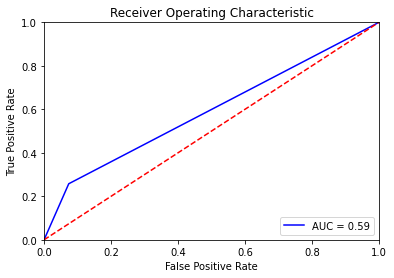

In [98]:
#Run Models
for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)


Optimized Model

Model Name: LogisticRegression(C=0.01, class_weight='balanced', max_iter=40000,
                   multi_class='multinomial', random_state=100)

Best Parameters: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

 [[529  41]
 [ 73  24]]

               precision    recall  f1-score   support

           0       0.88      0.93      0.90       570
           1       0.37      0.25      0.30        97

    accuracy                           0.83       667
   macro avg       0.62      0.59      0.60       667
weighted avg       0.80      0.83      0.81       667

ROC Curve


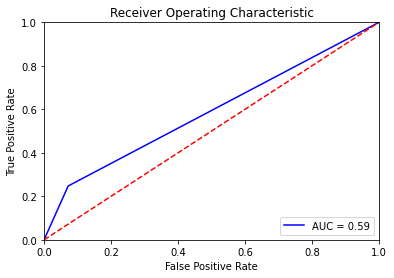

In [22]:
Gridsearch_cv(pipe_logreg,param_gridlogreg)

In [40]:
pipe_logreg.get_params().keys()


pipe_logreg.named_steps['clf']

LogisticRegression(class_weight='balanced', max_iter=40000,
                   multi_class='multinomial', random_state=100)